In [1]:
import pandas as pd
import numpy as np
import polars as pl

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

import xgboost as xgb
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import GroupShuffleSplit
from tqdm import tqdm

import statsmodels.api as sm

In [10]:
cp_path = "/dgx1nas1/storage/data/jess/repos/2024_09_09_Axiom_OASIS/1_snakemake/outputs/cellprofiler/mad_featselect/profiles/mad_featselect.parquet"
dino_path = "/dgx1nas1/storage/data/jess/repos/2024_09_09_Axiom_OASIS/1_snakemake/outputs/dino/mad_featselect/profiles/mad_featselect.parquet"
cpcnn_path = "/dgx1nas1/storage/data/jess/repos/2024_09_09_Axiom_OASIS/1_snakemake/outputs/cpcnn/mad_featselect/profiles/mad_featselect.parquet"

In [ ]:
def train_model(df, feat_cols, split_group, results_path, pred_vars, mean_pred = "no"):
    results = []
    for var in pred_vars:

        # Group split logic
        groups = df[split_group]
        gss = GroupShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
        
        for split_idx, (train_idx, test_idx) in tqdm(enumerate(gss.split(df, groups=groups)), desc=f"Processing {var}"):
            # Splitting the dataset
            train_data = df.iloc[train_idx]
            test_data = df.iloc[test_idx]

            train_data = train_data.dropna(subset=[var]).reset_index(drop=True)
            test_data = test_data.dropna(subset=[var]).reset_index(drop=True)
            
            X_train = train_data[feat_cols]
            y_train = train_data[var]
            X_test = test_data[feat_cols]
            y_test = test_data[var]

            if mean_pred == "yes":
                mean_value = np.mean(y_train)
                predictions = np.full(len(y_test), mean_value)
            else: 
                model = xgb.XGBRegressor(objective="reg:squarederror")
                model.fit(X_train, y_train)
                predictions = model.predict(X_test)

            # Calculate performance
            mse = mean_squared_error(y_test, predictions)
            r2 = r2_score(y_test, predictions)
            rmse = np.sqrt(mse)
            mae = mean_absolute_error(y_test, predictions)

            results.append((var, split_idx, r2, rmse, mae))

    # Convert results to DataFrame for analysis
    results_df = pd.DataFrame(results, columns=["Variable", "Split", "R²", "RMSE", "MAE"])

    # Save results
    results_df.to_csv(results_path, index=False)

In [36]:
def train_model_nozero(df, feat_cols, split_group, results_path, pred_vars, mean_pred = "no"):
    results = []
    for var in pred_vars:

        if "mtt" in var:
            nozero_df = df[df[var] < 1].reset_index(drop=True)
        else:
            nozero_df = df[df[var] > 0].reset_index(drop=True)

        # Group split logic
        groups = nozero_df[split_group]
        gss = GroupShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
        
        for split_idx, (train_idx, test_idx) in tqdm(enumerate(gss.split(nozero_df, groups=groups)), desc=f"Processing {var}"):
            # Splitting the dataset
            train_data = nozero_df.iloc[train_idx]
            test_data = nozero_df.iloc[test_idx]

            train_data = train_data.dropna(subset=[var]).reset_index(drop=True)
            test_data = test_data.dropna(subset=[var]).reset_index(drop=True)
            
            X_train = train_data[feat_cols]
            y_train = train_data[var]
            X_test = test_data[feat_cols]
            y_test = test_data[var]

            if mean_pred == "yes":
                mean_value = np.mean(y_train)
                predictions = np.full(len(y_test), mean_value)
            else: 
                model = xgb.XGBRegressor(objective="reg:squarederror")
                model.fit(X_train, y_train)
                predictions = model.predict(X_test)
            
            # Calculate performance
            mse = mean_squared_error(y_test, predictions)
            r2 = r2_score(y_test, predictions)
            rmse = np.sqrt(mse)
            mae = mean_absolute_error(y_test, predictions)

            results.append((var, split_idx, r2, rmse, mae))

    # Convert results to DataFrame for analysis
    results_df = pd.DataFrame(results, columns=["Variable", "Split", "R²", "RMSE", "MAE"])

    # Save results
    results_df.to_csv(results_path, index=False)

In [13]:
def process_prof(dat_path):
    df = pd.read_parquet(dat_path)
    morph_feats = [i for i in df.columns if "Metadata" not in i]
    meta_feats = [i for i in df.columns if "Metadata" in i]

    df = df[df["Metadata_Perturbation"] != "DMSO_0.0"].reset_index(drop=True)

    df["Metadata_Log10Conc"] = np.round(df["Metadata_Log10Conc"], 2)

    # Encoding categorical columns
    df["Metadata_Plate"] = df["Metadata_Plate"].astype("category").cat.codes
    df["Metadata_source"] = df["Metadata_source"].astype("category").cat.codes
    df["Metadata_Well"] = df["Metadata_Well"].astype("category").cat.codes
    df["Metadata_Compound"] = df["Metadata_Compound"].astype("category").cat.codes

    return df


In [19]:
# Define a function to plot violin and swarm plots grouped by variable types
def violin_swarm_plot_by_variable(dataframes, variable_type, metric, custom_labels):
    combined_data = []
    for label, df in dataframes.items():
        # Filter rows based on the variable type
        filtered_df = df[df['Variable'].str.contains(variable_type)]
        if metric in metrics:
            for index, value in filtered_df[metric].items():
                combined_data.append({"Dataset": label.split('/')[-1], "Variable": variable_type, metric: value})
    
    # Convert combined data to DataFrame for plotting
    combined_df = pd.DataFrame(combined_data)
    
    plt.figure(figsize=(5, 5), dpi=100)
    sns.violinplot(data=combined_df, x="Dataset", y=metric, inner="box", palette="Accent", hue="Dataset", legend=False)
    sns.swarmplot(data=combined_df, x="Dataset", y=metric, color="k", alpha=1, s=3)
    
    # Set custom labels
    plt.xlabel("Dataset")
    plt.ylabel(metric)
    plt.xticks(ticks=range(len(custom_labels)), labels=custom_labels, rotation=90)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

In [ ]:
# Process input data
cp_df = process_prof(cp_path)
dino_df = process_prof(dino_path)
cpcnn_df = process_prof(cpcnn_path)

cp_feat = [i for i in cp_df.columns if "Metadata" not in i]
dino_feat = [i for i in dino_df.columns if "Metadata" not in i]
cpcnn_feat = [i for i in cpcnn_df.columns if "Metadata" not in i]

## normalized

In [ ]:
# Generate all results

train_model(df, 
            ["Metadata_source", "Metadata_Plate", "Metadata_Well", "Metadata_Log10Conc", "Metadata_Count_Cells"],
            "Metadata_Compound",
            "baseline_results/grouped_results_compound_split_baseline.csv",
            ['Metadata_ldh_normalized', 'Metadata_mtt_normalized'])
print("Done 1")


train_model(df, 
            ["Metadata_source", "Metadata_Plate", "Metadata_Well", "Metadata_Count_Cells"],
            "Metadata_Compound",
            "baseline_results/grouped_results_compound_split_source_well_plate_cc_baseline.csv",
            ['Metadata_ldh_normalized', 'Metadata_mtt_normalized'])
print("Done 2")

train_model(df, 
            ["Metadata_Count_Cells"],
            "Metadata_Compound",
            "baseline_results/grouped_results_compound_split_cc_baseline.csv",
            ['Metadata_ldh_normalized', 'Metadata_mtt_normalized'])
print("Done 3")

train_model(df, 
            ["Metadata_source", "Metadata_Well", "Metadata_Count_Cells"],
            "Metadata_Compound",
            "baseline_results/grouped_results_compound_split_source_well_cc_baseline.csv",
            ['Metadata_ldh_normalized', 'Metadata_mtt_normalized'])
print("Done 4")

train_model(df, 
            ["Metadata_source", "Metadata_Plate", "Metadata_Count_Cells"],
            "Metadata_Compound",
            "baseline_results/grouped_results_compound_split_source_plate_cc_baseline.csv",
            ['Metadata_ldh_normalized', 'Metadata_mtt_normalized'])
print("Done 5")

train_model(df, 
            ["Metadata_Plate", "Metadata_Well", "Metadata_Count_Cells"],
            "Metadata_Compound",
            "baseline_results/grouped_results_compound_split_plate_well_cc_baseline.csv",
            ['Metadata_ldh_normalized', 'Metadata_mtt_normalized'])
print("Done 6")

train_model(df, 
            ["Metadata_Well", "Metadata_Count_Cells"],
            "Metadata_Compound",
            "baseline_results/grouped_results_compound_split_well_cc_baseline.csv",
            ['Metadata_ldh_normalized', 'Metadata_mtt_normalized'])
print("Done 7")

train_model(df, 
            ["Metadata_Well"],
            "Metadata_Compound",
            "baseline_results/grouped_results_compound_split_well_baseline.csv",
            ['Metadata_ldh_normalized', 'Metadata_mtt_normalized'])
print("Done 8")

train_model(df, 
            ["Metadata_source", "Metadata_Plate", "Metadata_Well"],
            "Metadata_Compound",
            "baseline_results/grouped_results_compound_split_source_plate_well_baseline.csv",
            ['Metadata_ldh_normalized', 'Metadata_mtt_normalized'])
print("Done 9")

train_model(df, 
            morph_feats,
            "Metadata_Compound",
            "baseline_results/grouped_results_compound_split_morph.csv",
            ['Metadata_ldh_normalized', 'Metadata_mtt_normalized'])
print("Done 10")

Processing Metadata_ldh_normalized: 5it [00:02,  1.91it/s]
Processing Metadata_mtt_normalized: 5it [00:03,  1.37it/s]

Done 1


In [ ]:
import pandas as pd

# Load the datasets
file_paths = [
    "baseline_results/grouped_results_compound_split_baseline.csv",
    "baseline_results/grouped_results_compound_split_source_well_plate_cc_baseline.csv",
    "baseline_results/grouped_results_compound_split_cc_baseline.csv",
    "baseline_results/grouped_results_compound_split_source_well_cc_baseline.csv",
    "baseline_results/grouped_results_compound_split_source_plate_cc_baseline.csv",
    "baseline_results/grouped_results_compound_split_plate_well_cc_baseline.csv",
    "baseline_results/grouped_results_compound_split_well_cc_baseline.csv",
    "baseline_results/grouped_results_compound_split_well_baseline.csv",
    "baseline_results/grouped_results_compound_split_source_plate_well_baseline.csv",
    "baseline_results/grouped_results_compound_split_morph.csv",
]

custom_labels = [path.replace("baseline_results/grouped_results_compound_split_", "").replace(".csv", "") for path in file_paths]

# Reading the CSV files into DataFrames
dataframes = {path: pd.read_csv(path) for path in file_paths}
metrics = ["R²", "RMSE", "MAE"]

Metadata_ldh_normalized


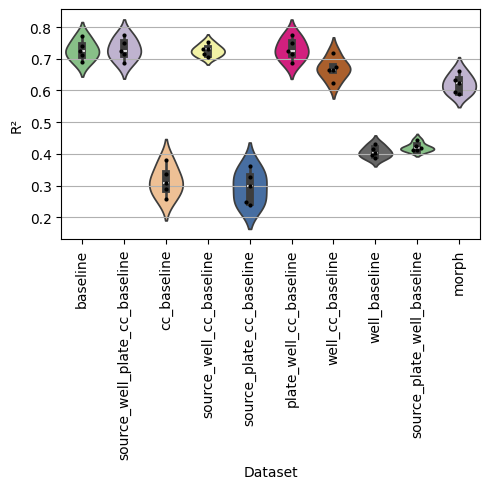

Metadata_ldh_normalized


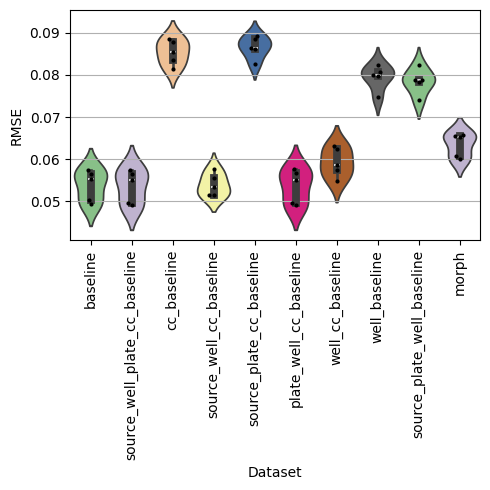

Metadata_ldh_normalized


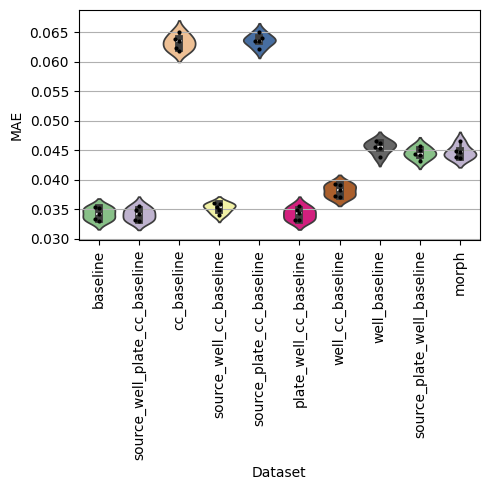

Metadata_mtt_normalized


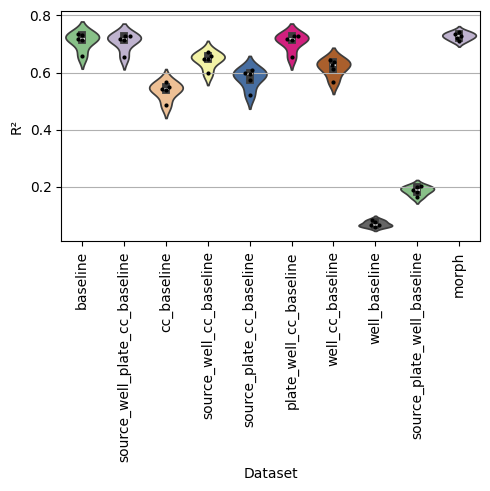

Metadata_mtt_normalized


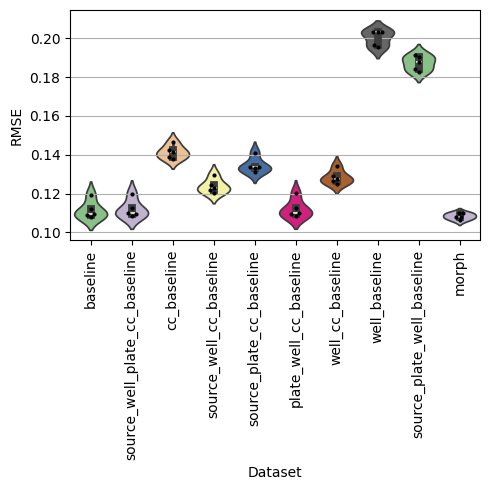

Metadata_mtt_normalized


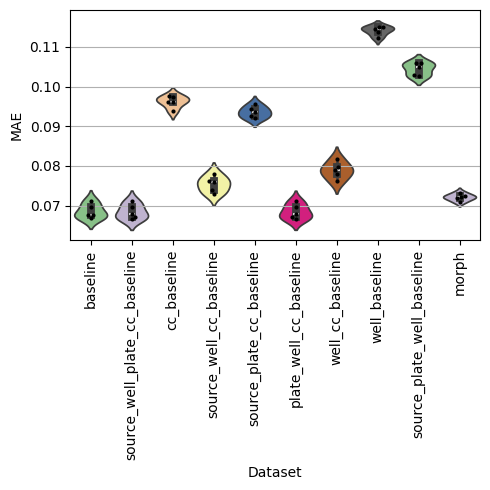

In [ ]:
# Generate plots for both variable types
variable_types = ['Metadata_ldh_normalized', 'Metadata_mtt_normalized']
for variable_type in variable_types:
    for metric in metrics:
        print(variable_type)
        violin_swarm_plot_by_variable(dataframes, variable_type, metric, custom_labels)


## For ridge-norm

In [ ]:
# Generate all results

train_model(df, 
            ["Metadata_source", "Metadata_Plate", "Metadata_Well", "Metadata_Log10Conc", "Metadata_Count_Cells"],
            "Metadata_Compound",
            "baseline_ridgenorm/grouped_results_compound_split_baseline.csv",
            ['Metadata_ldh_ridge_norm', 'Metadata_mtt_ridge_norm'])
print("Done 1")


train_model(df, 
            ["Metadata_source", "Metadata_Plate", "Metadata_Well", "Metadata_Count_Cells"],
            "Metadata_Compound",
            "baseline_ridgenorm/grouped_results_compound_split_source_well_plate_cc_baseline.csv",
            ['Metadata_ldh_ridge_norm', 'Metadata_mtt_ridge_norm'])
print("Done 2")

train_model(df, 
            ["Metadata_Count_Cells"],
            "Metadata_Compound",
            "baseline_ridgenorm/grouped_results_compound_split_cc_baseline.csv",
            ['Metadata_ldh_ridge_norm', 'Metadata_mtt_ridge_norm'])
print("Done 3")

train_model(df, 
            ["Metadata_source", "Metadata_Well", "Metadata_Count_Cells"],
            "Metadata_Compound",
            "baseline_ridgenorm/grouped_results_compound_split_source_well_cc_baseline.csv",
            ['Metadata_ldh_ridge_norm', 'Metadata_mtt_ridge_norm'])
print("Done 4")

train_model(df, 
            ["Metadata_source", "Metadata_Plate", "Metadata_Count_Cells"],
            "Metadata_Compound",
            "baseline_ridgenorm/grouped_results_compound_split_source_plate_cc_baseline.csv",
            ['Metadata_ldh_ridge_norm', 'Metadata_mtt_ridge_norm'])
print("Done 5")

train_model(df, 
            ["Metadata_Plate", "Metadata_Well", "Metadata_Count_Cells"],
            "Metadata_Compound",
            "baseline_ridgenorm/grouped_results_compound_split_plate_well_cc_baseline.csv",
            ['Metadata_ldh_ridge_norm', 'Metadata_mtt_ridge_norm'])
print("Done 6")

train_model(df, 
            ["Metadata_Well", "Metadata_Count_Cells"],
            "Metadata_Compound",
            "baseline_ridgenorm/grouped_results_compound_split_well_cc_baseline.csv",
            ['Metadata_ldh_ridge_norm', 'Metadata_mtt_ridge_norm'])
print("Done 7")

train_model(df, 
            ["Metadata_Well"],
            "Metadata_Compound",
            "baseline_ridgenorm/grouped_results_compound_split_well_baseline.csv",
            ['Metadata_ldh_ridge_norm', 'Metadata_mtt_ridge_norm'])
print("Done 8")

train_model(df, 
            ["Metadata_source", "Metadata_Plate", "Metadata_Well"],
            "Metadata_Compound",
            "baseline_ridgenorm/grouped_results_compound_split_source_plate_well_baseline.csv",
            ['Metadata_ldh_ridge_norm', 'Metadata_mtt_ridge_norm'])
print("Done 9")

train_model(df, 
            morph_feats,
            "Metadata_Compound",
            "baseline_ridgenorm/grouped_results_compound_split_morph.csv",
            ['Metadata_ldh_ridge_norm', 'Metadata_mtt_ridge_norm'])
print("Done 10")

In [26]:
import pandas as pd

# Load the datasets
file_paths = [
    "baseline_ridgenorm/grouped_results_compound_split_baseline.csv",
    "baseline_ridgenorm/grouped_results_compound_split_source_well_plate_cc_baseline.csv",
    "baseline_ridgenorm/grouped_results_compound_split_cc_baseline.csv",
    "baseline_ridgenorm/grouped_results_compound_split_source_well_cc_baseline.csv",
    "baseline_ridgenorm/grouped_results_compound_split_source_plate_cc_baseline.csv",
    "baseline_ridgenorm/grouped_results_compound_split_plate_well_cc_baseline.csv",
    "baseline_ridgenorm/grouped_results_compound_split_well_cc_baseline.csv",
    "baseline_ridgenorm/grouped_results_compound_split_well_baseline.csv",
    "baseline_ridgenorm/grouped_results_compound_split_source_plate_well_baseline.csv",
    "baseline_ridgenorm/grouped_results_compound_split_morph.csv",
]

custom_labels = [path.replace("baseline_ridgenorm/grouped_results_compound_split_", "").replace(".csv", "") for path in file_paths]

# Reading the CSV files into DataFrames
dataframes = {path: pd.read_csv(path) for path in file_paths}
metrics = ["R²", "RMSE", "MAE"]

Metadata_ldh_ridge_norm


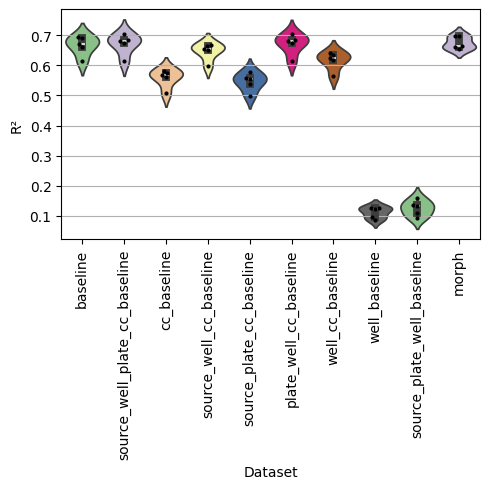

Metadata_ldh_ridge_norm


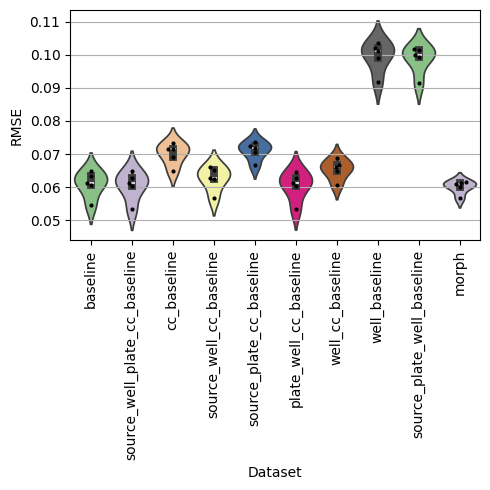

Metadata_ldh_ridge_norm


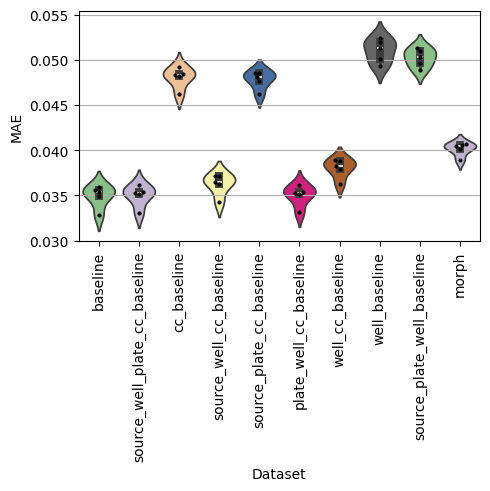

Metadata_mtt_ridge_norm


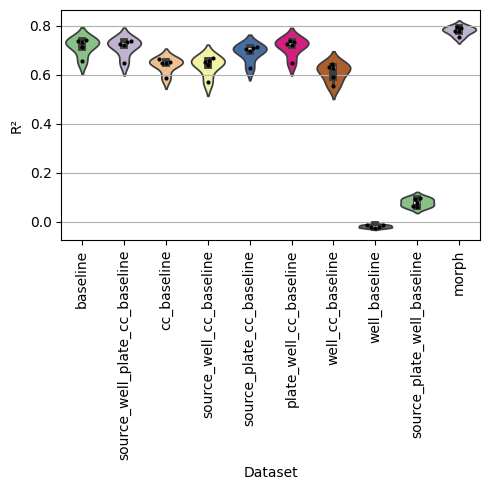

Metadata_mtt_ridge_norm


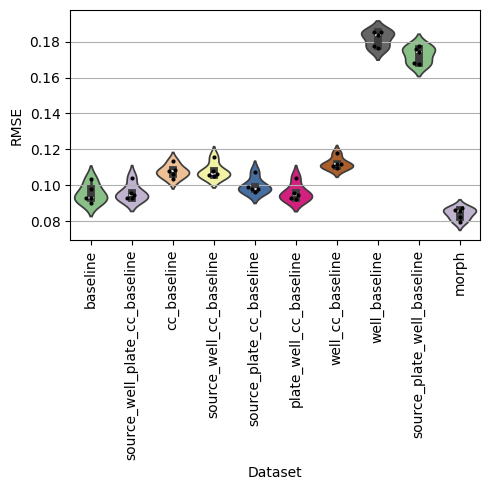

Metadata_mtt_ridge_norm


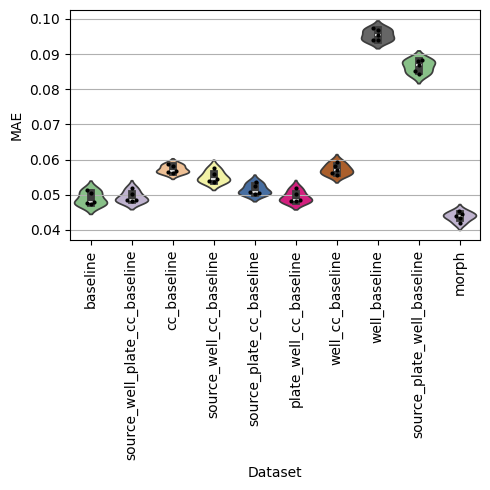

In [ ]:
# Generate plots for both variable types
variable_types = ['Metadata_ldh_ridge_norm', 'Metadata_mtt_ridge_norm']
for variable_type in variable_types:
    for metric in metrics:
        print(variable_type)
        violin_swarm_plot_by_variable(dataframes, variable_type, metric, custom_labels)


### Ridgenorm, remove 0s (LDH) and 1s (MTT)

In [ ]:
# Generate all results

train_model_nozero(df, 
            ["Metadata_source", "Metadata_Plate", "Metadata_Well"],
            "Metadata_Compound",
            "baseline_ridgenorm/grouped_results_compound_split_mean_baseline.csv",
            ['Metadata_ldh_ridge_norm', 'Metadata_mtt_ridge_norm'],
            "yes")
print("Done 1")


train_model_nozero(df, 
            ["Metadata_source", "Metadata_Plate", "Metadata_Well", "Metadata_Count_Cells"],
            "Metadata_Compound",
            "baseline_ridgenorm/grouped_results_compound_split_source_well_plate_cc_baseline.csv",
            ['Metadata_ldh_ridge_norm', 'Metadata_mtt_ridge_norm'])
print("Done 2")

train_model_nozero(df, 
            ["Metadata_Count_Cells"],
            "Metadata_Compound",
            "baseline_ridgenorm/grouped_results_compound_split_cc_baseline.csv",
            ['Metadata_ldh_ridge_norm', 'Metadata_mtt_ridge_norm'])
print("Done 3")

train_model_nozero(df, 
            ["Metadata_source", "Metadata_Well", "Metadata_Count_Cells"],
            "Metadata_Compound",
            "baseline_ridgenorm/grouped_results_compound_split_source_well_cc_baseline.csv",
            ['Metadata_ldh_ridge_norm', 'Metadata_mtt_ridge_norm'])
print("Done 4")

train_model_nozero(df, 
            ["Metadata_source", "Metadata_Plate", "Metadata_Count_Cells"],
            "Metadata_Compound",
            "baseline_ridgenorm/grouped_results_compound_split_source_plate_cc_baseline.csv",
            ['Metadata_ldh_ridge_norm', 'Metadata_mtt_ridge_norm'])
print("Done 5")

train_model_nozero(df, 
            ["Metadata_Plate", "Metadata_Well", "Metadata_Count_Cells"],
            "Metadata_Compound",
            "baseline_ridgenorm/grouped_results_compound_split_plate_well_cc_baseline.csv",
            ['Metadata_ldh_ridge_norm', 'Metadata_mtt_ridge_norm'])
print("Done 6")

train_model_nozero(df, 
            ["Metadata_Well", "Metadata_Count_Cells"],
            "Metadata_Compound",
            "baseline_ridgenorm/grouped_results_compound_split_well_cc_baseline.csv",
            ['Metadata_ldh_ridge_norm', 'Metadata_mtt_ridge_norm'])
print("Done 7")

train_model_nozero(df, 
            ["Metadata_Well"],
            "Metadata_Compound",
            "baseline_ridgenorm/grouped_results_compound_split_well_baseline.csv",
            ['Metadata_ldh_ridge_norm', 'Metadata_mtt_ridge_norm'])
print("Done 8")

train_model_nozero(df, 
            ["Metadata_source", "Metadata_Plate", "Metadata_Well"],
            "Metadata_Compound",
            "baseline_ridgenorm/grouped_results_compound_split_source_plate_well_baseline.csv",
            ['Metadata_ldh_ridge_norm', 'Metadata_mtt_ridge_norm'])
print("Done 9")

train_model_nozero(df, 
            morph_feats,
            "Metadata_Compound",
            "baseline_ridgenorm/grouped_results_compound_split_morph.csv",
            ['Metadata_ldh_ridge_norm', 'Metadata_mtt_ridge_norm'])
print("Done 10")

In [ ]:
# Load the datasets
file_paths = [
    "baseline_ridgenorm/grouped_results_compound_split_mean_baseline.csv",
    "baseline_ridgenorm/grouped_results_compound_split_source_well_plate_cc_baseline.csv",
    "baseline_ridgenorm/grouped_results_compound_split_cc_baseline.csv",
    "baseline_ridgenorm/grouped_results_compound_split_source_well_cc_baseline.csv",
    "baseline_ridgenorm/grouped_results_compound_split_source_plate_cc_baseline.csv",
    "baseline_ridgenorm/grouped_results_compound_split_plate_well_cc_baseline.csv",
    "baseline_ridgenorm/grouped_results_compound_split_well_cc_baseline.csv",
    "baseline_ridgenorm/grouped_results_compound_split_well_baseline.csv",
    "baseline_ridgenorm/grouped_results_compound_split_source_plate_well_baseline.csv",
    "baseline_ridgenorm/grouped_results_compound_split_morph.csv",
]

custom_labels = [path.replace("baseline_ridgenorm/grouped_results_compound_split_", "").replace(".csv", "") for path in file_paths]

# Reading the CSV files into DataFrames
dataframes = {path: pd.read_csv(path) for path in file_paths}
metrics = ["R²", "RMSE", "MAE"]

Metadata_ldh_ridge_norm


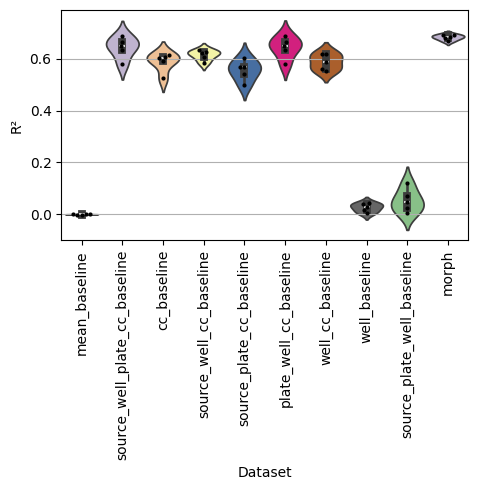

Metadata_ldh_ridge_norm


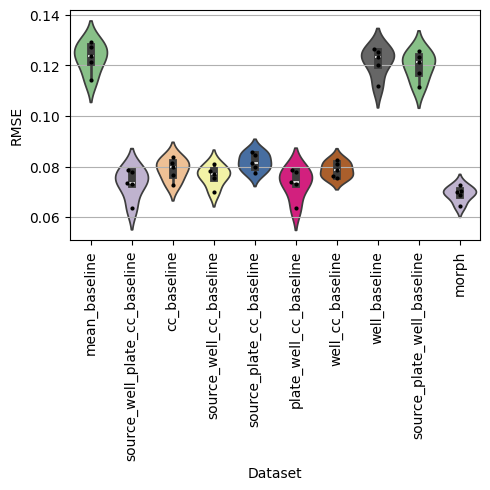

Metadata_ldh_ridge_norm


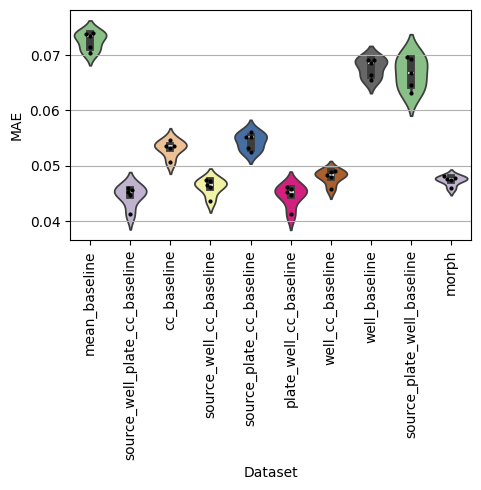

Metadata_mtt_ridge_norm


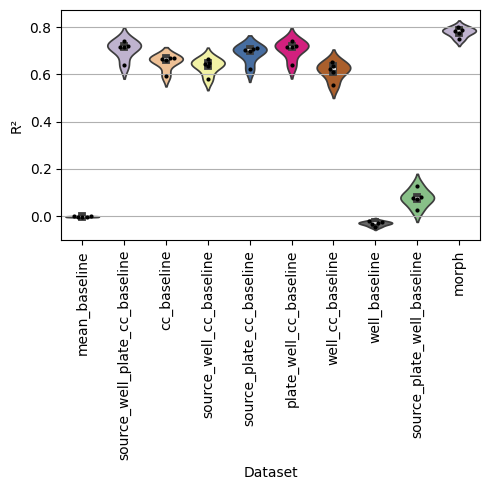

Metadata_mtt_ridge_norm


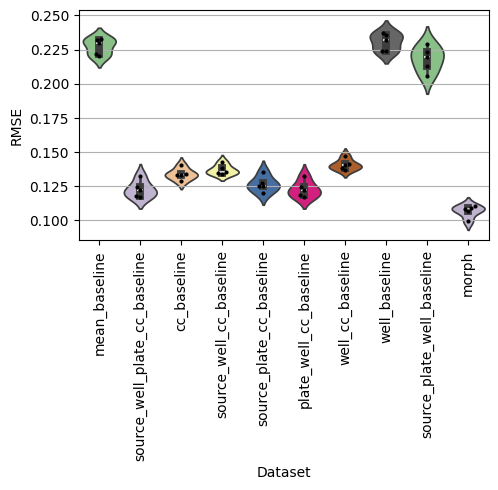

Metadata_mtt_ridge_norm


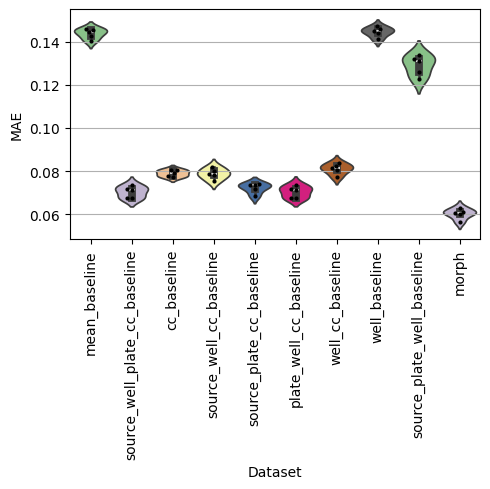

In [ ]:
# Generate plots for both variable types
variable_types = ['Metadata_ldh_ridge_norm', 'Metadata_mtt_ridge_norm']
for variable_type in variable_types:
    for metric in metrics:
        print(variable_type)
        violin_swarm_plot_by_variable(dataframes, variable_type, metric, custom_labels)

## With profile well-position correction, no 1s/0s

In [ ]:
# Substract mean of each well position from profiles
df_well = pl.from_pandas(df)
df_well = df_well.with_columns(pl.col(morph_feats) - pl.mean(morph_feats).over("Metadata_Well")).to_pandas()


In [ ]:
# Generate all results
train_model_nozero(df_well, 
            morph_feats,
            "Metadata_Compound",
            "baseline_ridgenorm/grouped_results_compound_split_morph.csv",
            ['Metadata_ldh_ridge_norm', 'Metadata_mtt_ridge_norm'])
print("Done 1")

Metadata_ldh_ridge_norm


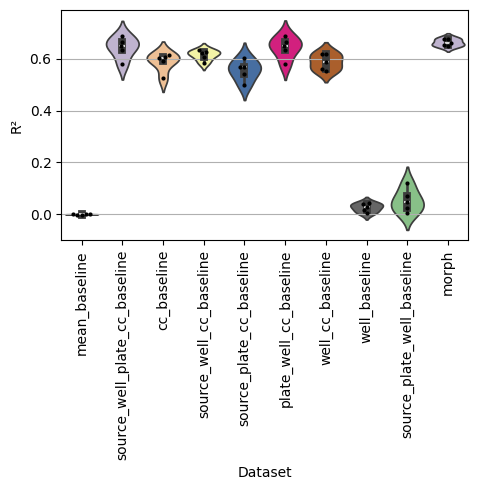

Metadata_ldh_ridge_norm


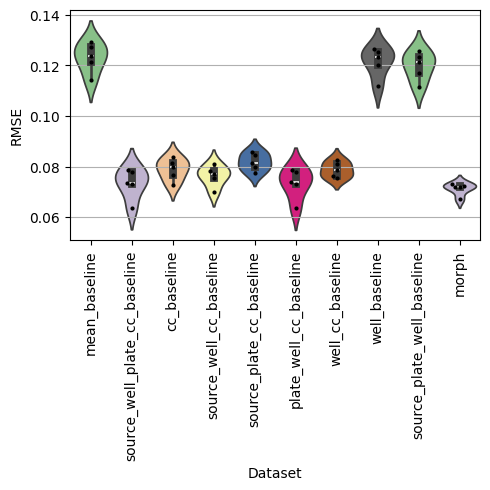

Metadata_ldh_ridge_norm


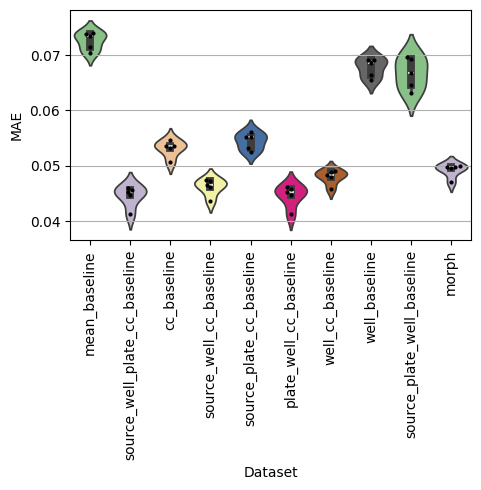

Metadata_mtt_ridge_norm


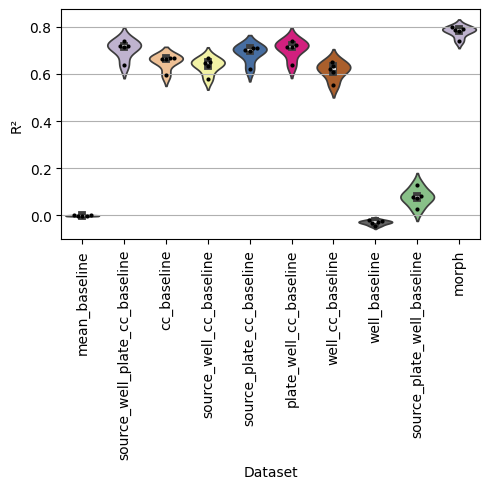

Metadata_mtt_ridge_norm


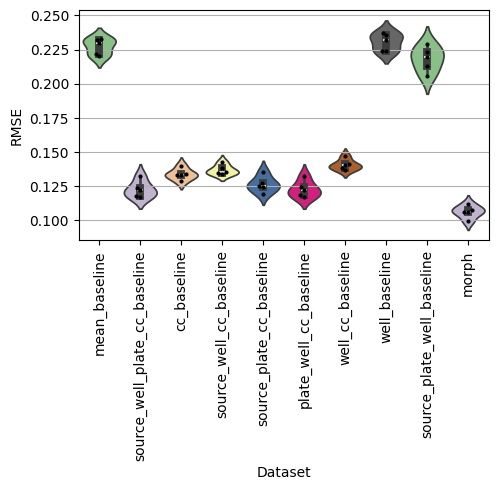

Metadata_mtt_ridge_norm


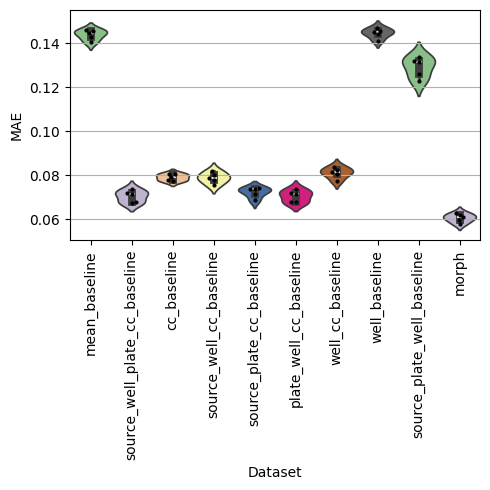

In [ ]:
# Load the datasets
file_paths = [
    "baseline_ridgenorm/grouped_results_compound_split_mean_baseline.csv",
    "baseline_ridgenorm/grouped_results_compound_split_source_well_plate_cc_baseline.csv",
    "baseline_ridgenorm/grouped_results_compound_split_cc_baseline.csv",
    "baseline_ridgenorm/grouped_results_compound_split_source_well_cc_baseline.csv",
    "baseline_ridgenorm/grouped_results_compound_split_source_plate_cc_baseline.csv",
    "baseline_ridgenorm/grouped_results_compound_split_plate_well_cc_baseline.csv",
    "baseline_ridgenorm/grouped_results_compound_split_well_cc_baseline.csv",
    "baseline_ridgenorm/grouped_results_compound_split_well_baseline.csv",
    "baseline_ridgenorm/grouped_results_compound_split_source_plate_well_baseline.csv",
    "baseline_ridgenorm/grouped_results_compound_split_morph.csv",
]

custom_labels = [path.replace("baseline_ridgenorm/grouped_results_compound_split_", "").replace(".csv", "") for path in file_paths]

# Reading the CSV files into DataFrames
dataframes = {path: pd.read_csv(path) for path in file_paths}
metrics = ["R²", "RMSE", "MAE"]
    
# Generate plots for both variable types
variable_types = ['Metadata_ldh_ridge_norm', 'Metadata_mtt_ridge_norm']
for variable_type in variable_types:
    for metric in metrics:
        print(variable_type)
        violin_swarm_plot_by_variable(dataframes, variable_type, metric, custom_labels)

## Subtract median of MTT and LDH normalized values, by well & source

In [30]:
df_well = pl.from_pandas(cp_df)
df_well = df_well.with_columns(pl.col(['Metadata_ldh_normalized', 'Metadata_mtt_normalized']) - pl.median(['Metadata_ldh_normalized', 'Metadata_mtt_normalized']).over("Metadata_Well")).to_pandas()

dino_df = pl.from_pandas(dino_df).with_columns(pl.col(['Metadata_ldh_normalized', 'Metadata_mtt_normalized']) - pl.median(['Metadata_ldh_normalized', 'Metadata_mtt_normalized']).over("Metadata_Well")).to_pandas()
cpcnn_df = pl.from_pandas(cpcnn_df).with_columns(pl.col(['Metadata_ldh_normalized', 'Metadata_mtt_normalized']) - pl.median(['Metadata_ldh_normalized', 'Metadata_mtt_normalized']).over("Metadata_Well")).to_pandas()

In [31]:
# Generate all results
train_model(df_well, 
            ["Metadata_source", "Metadata_Plate", "Metadata_Well"],
            "Metadata_Compound",
            "baseline_ridgenorm/grouped_results_compound_split_mean_baseline.csv",
            ['Metadata_ldh_normalized', 'Metadata_mtt_normalized'],
            "yes")
print("Done 1")


train_model(df_well, 
            ["Metadata_source", "Metadata_Plate", "Metadata_Well", "Metadata_Count_Cells"],
            "Metadata_Compound",
            "baseline_ridgenorm/grouped_results_compound_split_source_well_plate_cc_baseline.csv",
            ['Metadata_ldh_normalized', 'Metadata_mtt_normalized'])
print("Done 2")

train_model(df_well, 
            ["Metadata_Count_Cells"],
            "Metadata_Compound",
            "baseline_ridgenorm/grouped_results_compound_split_cc_baseline.csv",
            ['Metadata_ldh_normalized', 'Metadata_mtt_normalized'])
print("Done 3")

train_model(df_well, 
            ["Metadata_Well"],
            "Metadata_Compound",
            "baseline_ridgenorm/grouped_results_compound_split_well_baseline.csv",
            ['Metadata_ldh_normalized', 'Metadata_mtt_normalized'])
print("Done 4")

train_model(df_well, 
            ["Metadata_Plate"],
            "Metadata_Compound",
            "baseline_ridgenorm/grouped_results_compound_split_plate_baseline.csv",
            ['Metadata_ldh_normalized', 'Metadata_mtt_normalized'])
print("Done 5")

train_model(df_well, 
            ["Metadata_source"],
            "Metadata_Compound",
            "baseline_ridgenorm/grouped_results_compound_split_source_baseline.csv",
            ['Metadata_ldh_normalized', 'Metadata_mtt_normalized'])
print("Done 6")

train_model(df_well, 
            ["Metadata_source", "Metadata_Plate", "Metadata_Well"],
            "Metadata_Compound",
            "baseline_ridgenorm/grouped_results_compound_split_source_plate_well_baseline.csv",
            ['Metadata_ldh_normalized', 'Metadata_mtt_normalized'])
print("Done 7")

train_model(df_well, 
            cp_feat,
            "Metadata_Compound",
            "baseline_ridgenorm/grouped_results_compound_split_cellprofiler.csv",
            ['Metadata_ldh_normalized', 'Metadata_mtt_normalized'])
print("Done 8")

train_model(dino_df, 
            dino_feat,
            "Metadata_Compound",
            "baseline_ridgenorm/grouped_results_compound_split_dino.csv",
            ['Metadata_ldh_normalized', 'Metadata_mtt_normalized'])
print("Done 9")

train_model(cpcnn_df, 
            cpcnn_feat,
            "Metadata_Compound",
            "baseline_ridgenorm/grouped_results_compound_split_cpcnn.csv",
            ['Metadata_ldh_normalized', 'Metadata_mtt_normalized'])
print("Done 10")


Processing Metadata_ldh_normalized: 5it [01:19, 15.95s/it]
Processing Metadata_mtt_normalized: 5it [01:20, 16.17s/it]


Done 1


Processing Metadata_ldh_normalized: 5it [01:21, 16.36s/it]
Processing Metadata_mtt_normalized: 5it [01:23, 16.69s/it]


Done 2


Processing Metadata_ldh_normalized: 5it [01:16, 15.37s/it]
Processing Metadata_mtt_normalized: 5it [01:18, 15.60s/it]


Done 3


Processing Metadata_ldh_normalized: 5it [01:15, 15.06s/it]
Processing Metadata_mtt_normalized: 5it [01:18, 15.76s/it]


Done 4


Processing Metadata_ldh_normalized: 5it [00:29,  5.81s/it]
Processing Metadata_mtt_normalized: 5it [00:44,  9.00s/it]


Done 5


Processing Metadata_ldh_normalized: 5it [00:19,  3.94s/it]
Processing Metadata_mtt_normalized: 5it [00:16,  3.29s/it]


Done 6


Processing Metadata_ldh_normalized: 5it [01:13, 14.60s/it]
Processing Metadata_mtt_normalized: 5it [01:03, 12.68s/it]


Done 7


Processing Metadata_ldh_normalized: 5it [01:38, 19.64s/it]
Processing Metadata_mtt_normalized: 5it [01:38, 19.80s/it]


Done 8


Processing Metadata_ldh_normalized: 5it [03:54, 46.92s/it]
Processing Metadata_mtt_normalized: 5it [03:57, 47.48s/it]


Done 9


Processing Metadata_ldh_normalized: 5it [01:31, 18.26s/it]
Processing Metadata_mtt_normalized: 5it [00:41,  8.27s/it]

Done 10


Metadata_ldh_normalized


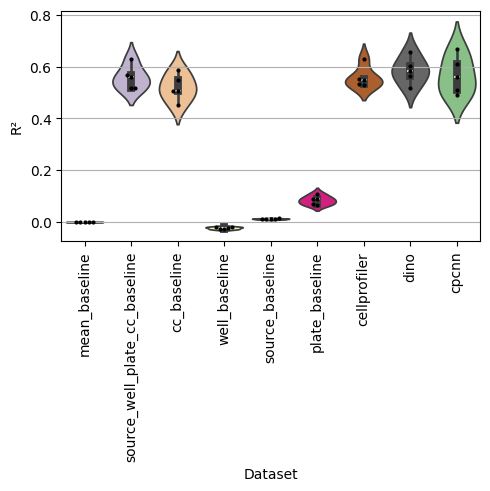

Metadata_ldh_normalized


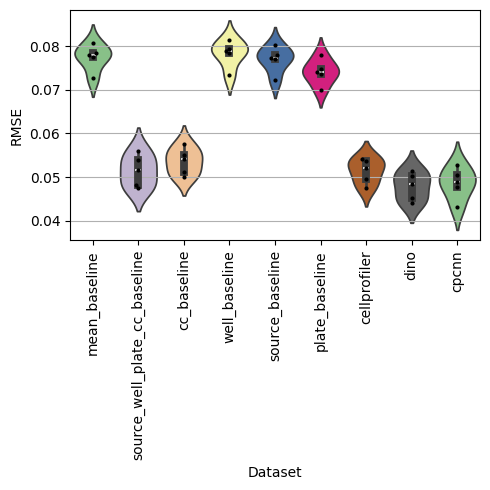

Metadata_ldh_normalized


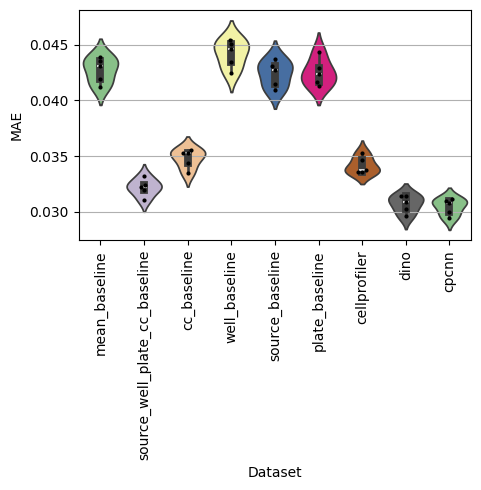

Metadata_mtt_normalized


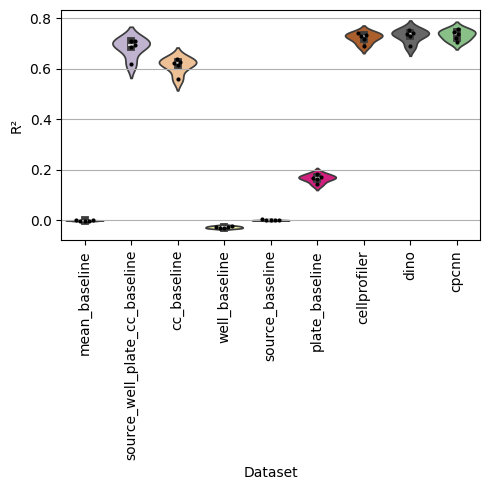

Metadata_mtt_normalized


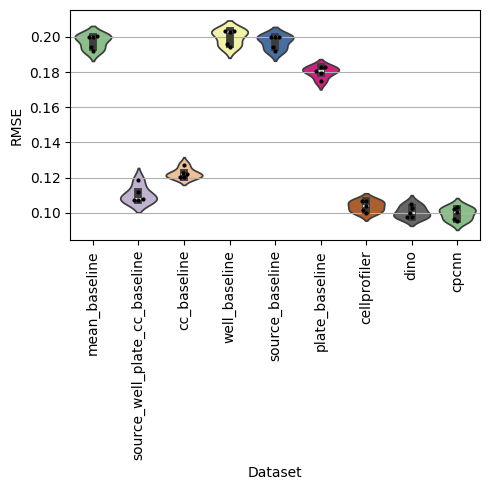

Metadata_mtt_normalized


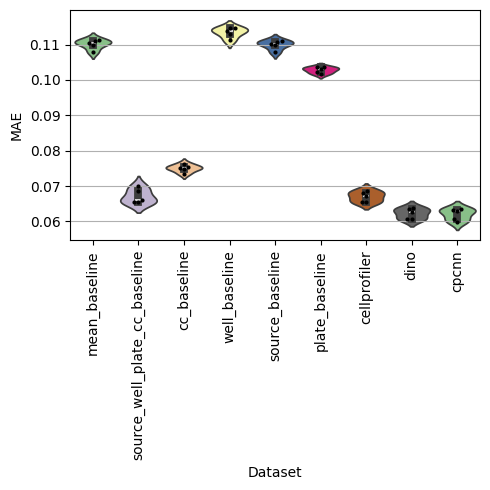

In [32]:
# Load the datasets
file_paths = [
    "baseline_ridgenorm/grouped_results_compound_split_mean_baseline.csv",
    "baseline_ridgenorm/grouped_results_compound_split_source_well_plate_cc_baseline.csv",
    "baseline_ridgenorm/grouped_results_compound_split_cc_baseline.csv",
    "baseline_ridgenorm/grouped_results_compound_split_well_baseline.csv",
    "baseline_ridgenorm/grouped_results_compound_split_source_baseline.csv",
    "baseline_ridgenorm/grouped_results_compound_split_plate_baseline.csv",
    "baseline_ridgenorm/grouped_results_compound_split_cellprofiler.csv",
    "baseline_ridgenorm/grouped_results_compound_split_dino.csv",
    "baseline_ridgenorm/grouped_results_compound_split_cpcnn.csv",
]

custom_labels = [path.replace("baseline_ridgenorm/grouped_results_compound_split_", "").replace(".csv", "") for path in file_paths]

# Reading the CSV files into DataFrames
dataframes = {path: pd.read_csv(path) for path in file_paths}
metrics = ["R²", "RMSE", "MAE"]
    
# Generate plots for both variable types
variable_types = ['Metadata_ldh_normalized', 'Metadata_mtt_normalized']
for variable_type in variable_types:
    for metric in metrics:
        print(variable_type)
        violin_swarm_plot_by_variable(dataframes, variable_type, metric, custom_labels)

## Try MTT and LDH normalized to cell count

In [ ]:
df = cp_df
df.loc[df["Metadata_ldh_ridge_norm"].isna(), "Metadata_ldh_normalized"] = pd.NA
df = pl.from_pandas(df).with_columns(pl.col(['Metadata_ldh_normalized', 'Metadata_mtt_normalized']) - pl.median(['Metadata_ldh_normalized', 'Metadata_mtt_normalized']).over("Metadata_Well")).to_pandas()

# This doesn't work at all
df['Metadata_ldh_cc'] = df['Metadata_ldh_normalized'] / df['Metadata_Count_Cells']
df['Metadata_mtt_cc'] = df['Metadata_mtt_normalized'] / df['Metadata_Count_Cells']

# MTT-cc resid
X = df["Metadata_Count_Cells"]
y = df["Metadata_mtt_normalized"]
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
df["Metadata_mtt_cc_resid"] = model.resid

# LDH-cc resid
valid_rows = df[["Metadata_Count_Cells", "Metadata_ldh_normalized"]].dropna()

X = valid_rows["Metadata_Count_Cells"]
y = valid_rows["Metadata_ldh_normalized"]
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
df["Metadata_ldh_cc_resid"] = pd.NA
df["Metadata_ldh_cc_resid"] = model.resid
df.loc[valid_rows.index, "Metadata_ldh_cc_resid"] = model.resid

In [45]:
# Generate all results
pred_vars = ['Metadata_ldh_cc_resid', 'Metadata_mtt_cc_resid']

train_model(df, 
            [],
            "Metadata_Compound",
            "baseline_ridgenorm/grouped_results_compound_split_mean_baseline.csv",
            pred_vars,
            "yes")
print("Done 1")


train_model(df, 
            ["Metadata_source", "Metadata_Plate", "Metadata_Well", "Metadata_Count_Cells"],
            "Metadata_Compound",
            "baseline_ridgenorm/grouped_results_compound_split_source_well_plate_cc_baseline.csv",
            pred_vars)
print("Done 2")

train_model(df, 
            ["Metadata_Count_Cells"],
            "Metadata_Compound",
            "baseline_ridgenorm/grouped_results_compound_split_cc_baseline.csv",
            pred_vars)
print("Done 3")

train_model(df, 
            ["Metadata_Well"],
            "Metadata_Compound",
            "baseline_ridgenorm/grouped_results_compound_split_well_baseline.csv",
            pred_vars)
print("Done 4")

train_model(df, 
            ["Metadata_Plate"],
            "Metadata_Compound",
            "baseline_ridgenorm/grouped_results_compound_split_plate_baseline.csv",
            pred_vars)
print("Done 5")

train_model(df, 
            ["Metadata_source"],
            "Metadata_Compound",
            "baseline_ridgenorm/grouped_results_compound_split_source_baseline.csv",
            pred_vars)
print("Done 6")

train_model(df, 
            ["Metadata_source", "Metadata_Plate", "Metadata_Well"],
            "Metadata_Compound",
            "baseline_ridgenorm/grouped_results_compound_split_source_plate_well_baseline.csv",
            pred_vars)
print("Done 7")

train_model(df, 
            cp_feat,
            "Metadata_Compound",
            "baseline_ridgenorm/grouped_results_compound_split_cellprofiler.csv",
            pred_vars)
print("Done 8")


Processing Metadata_ldh_cc_resid: 5it [00:00, 10.40it/s]
Processing Metadata_mtt_cc_resid: 5it [00:00, 11.76it/s]


Done 1


Processing Metadata_ldh_cc_resid: 5it [01:28, 17.63s/it]
Processing Metadata_mtt_cc_resid: 5it [01:27, 17.59s/it]


Done 2


Processing Metadata_ldh_cc_resid: 5it [01:26, 17.28s/it]
Processing Metadata_mtt_cc_resid: 5it [01:27, 17.55s/it]


Done 3


Processing Metadata_ldh_cc_resid: 5it [01:24, 16.83s/it]
Processing Metadata_mtt_cc_resid: 5it [01:27, 17.58s/it]


Done 4


Processing Metadata_ldh_cc_resid: 5it [00:40,  8.08s/it]
Processing Metadata_mtt_cc_resid: 5it [00:44,  8.92s/it]


Done 5


Processing Metadata_ldh_cc_resid: 5it [00:23,  4.68s/it]
Processing Metadata_mtt_cc_resid: 5it [00:20,  4.18s/it]


Done 6


Processing Metadata_ldh_cc_resid: 5it [01:28, 17.60s/it]
Processing Metadata_mtt_cc_resid: 5it [01:29, 17.84s/it]


Done 7


Processing Metadata_ldh_cc_resid: 5it [01:43, 20.71s/it]
Processing Metadata_mtt_cc_resid: 5it [01:46, 21.21s/it]

Done 8


Metadata_ldh_cc_resid


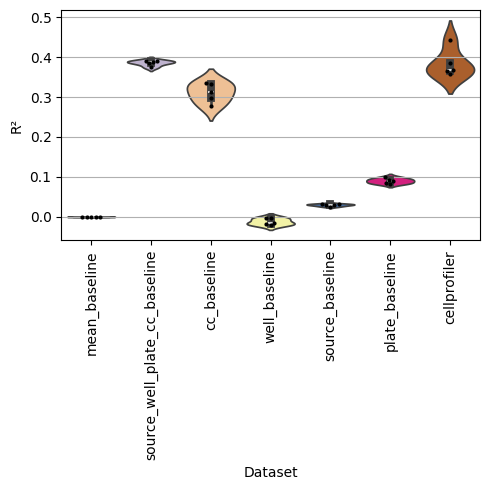

Metadata_ldh_cc_resid


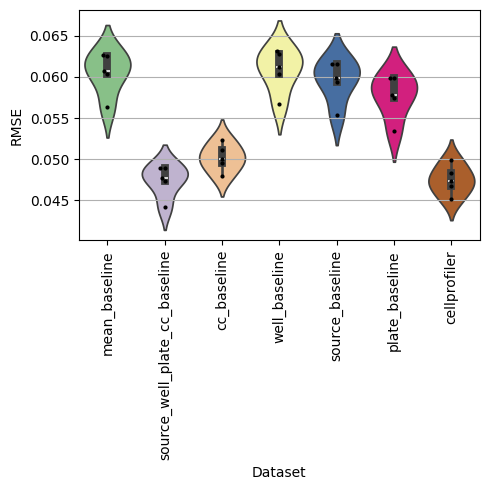

Metadata_ldh_cc_resid


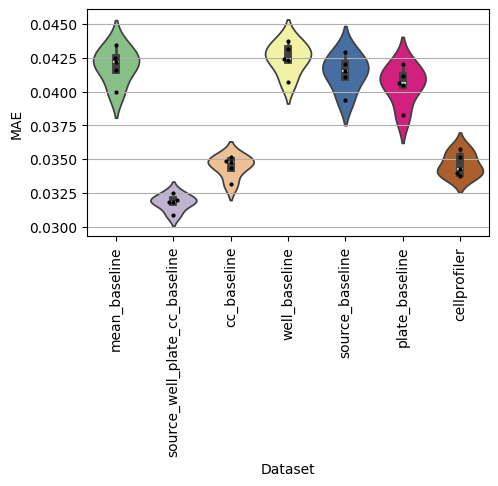

Metadata_mtt_cc_resid


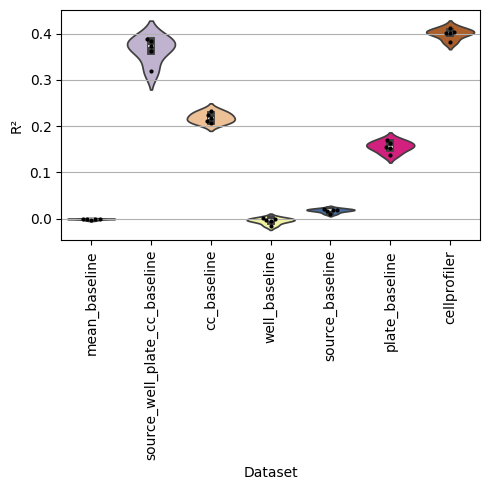

Metadata_mtt_cc_resid


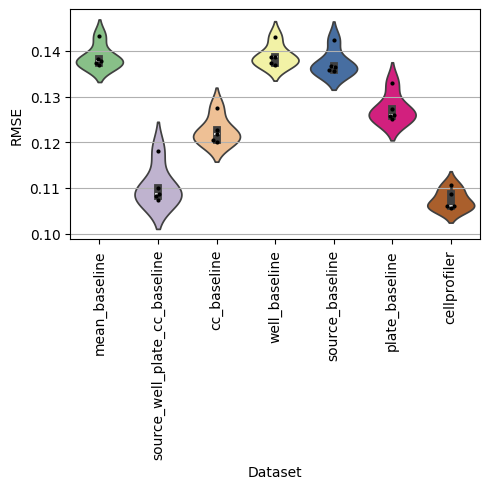

Metadata_mtt_cc_resid


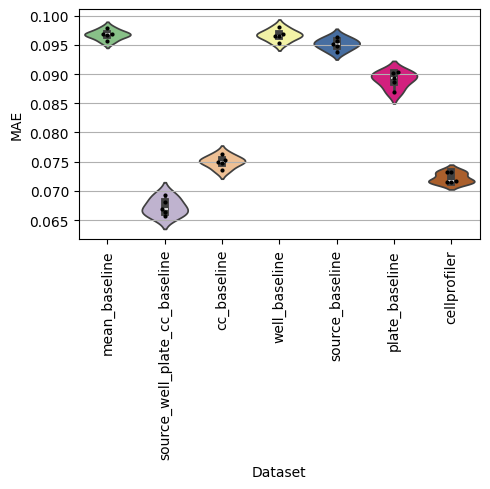

In [46]:
# Load the datasets
file_paths = [
    "baseline_ridgenorm/grouped_results_compound_split_mean_baseline.csv",
    "baseline_ridgenorm/grouped_results_compound_split_source_well_plate_cc_baseline.csv",
    "baseline_ridgenorm/grouped_results_compound_split_cc_baseline.csv",
    "baseline_ridgenorm/grouped_results_compound_split_well_baseline.csv",
    "baseline_ridgenorm/grouped_results_compound_split_source_baseline.csv",
    "baseline_ridgenorm/grouped_results_compound_split_plate_baseline.csv",
    "baseline_ridgenorm/grouped_results_compound_split_cellprofiler.csv",
]

custom_labels = [path.replace("baseline_ridgenorm/grouped_results_compound_split_", "").replace(".csv", "") for path in file_paths]

# Reading the CSV files into DataFrames
dataframes = {path: pd.read_csv(path) for path in file_paths}
metrics = ["R²", "RMSE", "MAE"]
    
# Generate plots for both variable types
variable_types = pred_vars
for variable_type in variable_types:
    for metric in metrics:
        print(variable_type)
        violin_swarm_plot_by_variable(dataframes, variable_type, metric, custom_labels)